<a href="https://colab.research.google.com/github/cassandra-wong/emotion-analysis/blob/main/emotion_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

import re
import nltk
from nltk.corpus import stopwords

import pickle


In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Dataset is obtained from [Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp).

In [ ]:
df_train = pd.read_csv("train.txt", names=["Text", "Emotions"], sep=';')
df_test = pd.read_csv("test.txt", names=["Text", "Emotions"], sep=';')
df_val = pd.read_csv("val.txt", names=["Text", "Emotions"], sep=';')

df_train.head()

,Text,Emotions
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df_train.shape

(16000, 2)

In [ ]:
len(df_train['Text'])

16000

In [ ]:
df_train.Emotions.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotions, dtype: int64

In [ ]:
# Assess distribution of data
df_train.Emotions.value_counts() / df_train.shape[0] *100

joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: Emotions, dtype: float64

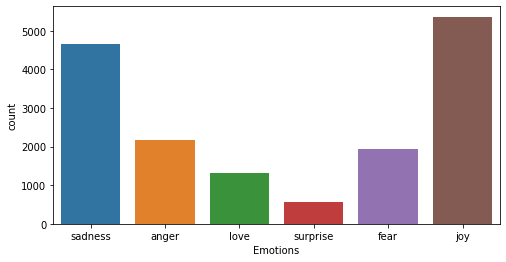

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotions', data=df_train);

## Text Preprocessing

We proceed to standardize the input sentence with a function and remove stop words (words that are filtered out as they don't add much context in NLP).

In [ ]:
stop_words = set(stopwords.words("english"))

def standarize_sentence(text):
    text = text.split()
    text = ' '.join([t.lower() for t in text])                                              #lower case
    text = ' '.join([i for i in str(text).split() if i not in stop_words])                  #no stop words
    text = ''.join([i for i in text if not i.isdigit()])                                    #no numbers
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)  #no punctuations and white space
    text = text.replace('؛','', )
    text = ' '.join(re.sub('\s+', ' ', text).split()).strip()
    return text

In [ ]:
def standard_df(df):
  for i in range(len(df)):
    sentence = df.loc[i, 'Text']
    df.loc[i, 'Text'] = standarize_sentence(sentence)
  return df

In [ ]:
df_train = standard_df(df_train)
df_test = standard_df(df_test)
df_val = standard_df(df_val)

In [ ]:
["Text", "Emotions"]

['Text', 'Emotions']

In [ ]:
X_train = df_train['Text'].tolist()
y_train = df_train['Emotions'].tolist()

X_test = df_test['Text'].tolist()
y_test = df_test['Emotions'].tolist()

X_val = df_val['Text'].tolist()
y_val = df_val['Emotions'].tolist()

In [ ]:
len(X_train)

16000

In [ ]:
df_train.isnull().sum()

Text        0
Emotions    0
dtype: int64

Tokenization refers to a task to split a sentence into smaller units (i.e., individual words), or tokens.

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# Pad sequence to the same length (in this case, max len) for feeding into the NN
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [ ]:
max_length = max([len(seq) for seq in df_train['Text']])
max_length

232

In [ ]:
X_train = pad_sequences(sequences_train, maxlen=max_length, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_length, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=max_length, truncating='pre')

In [ ]:
X_train

array([[   0,    0,    0, ...,   49,    1,  562],
       [   0,    0,    0, ...,   55, 1349, 1125],
       [   0,    0,    0, ...,    1,  381,  326],
       ...,
       [   0,    0,    0, ...,  218,   32, 1201],
       [   0,    0,    0, ..., 1106,    4,  230],
       [   0,    0,    0, ...,    1,  175, 3444]], dtype=int32)

In [ ]:
# Use label encoder to change string labels to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [ ]:
# One-hot encode labels
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

In [ ]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

## Classification Model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=128, input_length=max_length))
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=len(y_train[0]), activation="softmax"))

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 232, 128)          1928320   
                                                                 
 flatten (Flatten)           (None, 29696)             0         
                                                                 
 dense (Dense)               (None, 128)               3801216   
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 5,730,310
Trainable params: 5,730,310
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
500/500 [==============================] - 32s 60ms/step - loss: 1.1395 - accuracy: 0.5866 - val_loss: 0.5724 - val_accuracy: 0.8320
Epoch 2/10
500/500 [==============================] - 25s 51ms/step - loss: 0.2625 - accuracy: 0.9194 - val_loss: 0.3909 - val_accuracy: 0.8770
Epoch 3/10
500/500 [==============================] - 26s 52ms/step - loss: 0.0820 - accuracy: 0.9757 - val_loss: 0.4296 - val_accuracy: 0.8725
Epoch 4/10
500/500 [==============================] - 28s 56ms/step - loss: 0.0407 - accuracy: 0.9893 - val_loss: 0.4481 - val_accuracy: 0.8715
Epoch 5/10
500/500 [==============================] - 26s 51ms/step - loss: 0.0276 - accuracy: 0.9932 - val_loss: 0.4965 - val_accuracy: 0.8765
Epoch 6/10
500/500 [==============================] - 26s 52ms/step - loss: 0.0206 - accuracy: 0.9946 - val_loss: 0.5245 - val_accuracy: 0.8680
Epoch 7/10
500/500 [==============================] - 26s 52ms/step - loss: 0.0197 - accuracy: 0.9948 - val_loss: 0.5831 - val_accuracy:

In [ ]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(label_encoder.transform(df_test['Emotions']), y_pred))

63/63 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       275
           1       0.85      0.74      0.79       224
           2       0.88      0.88      0.88       695
           3       0.73      0.74      0.73       159
           4       0.91      0.88      0.89       581
           5       0.60      0.71      0.65        66

    accuracy                           0.85      2000
   macro avg       0.79      0.81      0.80      2000
weighted avg       0.85      0.85      0.85      2000



## Testing Phase

The sentences used to train are cleaned (i.e., no punctuations, lower case, etc.) We proceed to standardize the input sentence with a function.

In [ ]:
def emotion_classify(input_text):
  print(input_text)
  input_text = standarize_sentence(input_text)
  input_text = tokenizer.texts_to_sequences([input_text])
  input_text = pad_sequences(input_text, maxlen=max_length, truncating='pre')
  result = label_encoder.inverse_transform(np.argmax(model.predict(input_text), axis=-1))[0]
  probs =  np.max(model.predict(input_text))
  print(f"{result} : {probs}\n\n")

In [ ]:
x = "She didn't come today because she lost her dog yestertay!"

emotion_classify(x)

She didn't come today because she lost her dog yestertay!
1/1 [==============================] - 0s 55ms/step
sadness : 0.9998538494110107




## Save Module using Pickle

In [ ]:
pickle.dump(model, open('model.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......embedding
.........vars
............0
......flatten
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-15 20:56:48         1934
variables.h5                                   2023-02-15 20:56:48     68788288
metadata.json                                  2023-02-15 20:56:48           64
